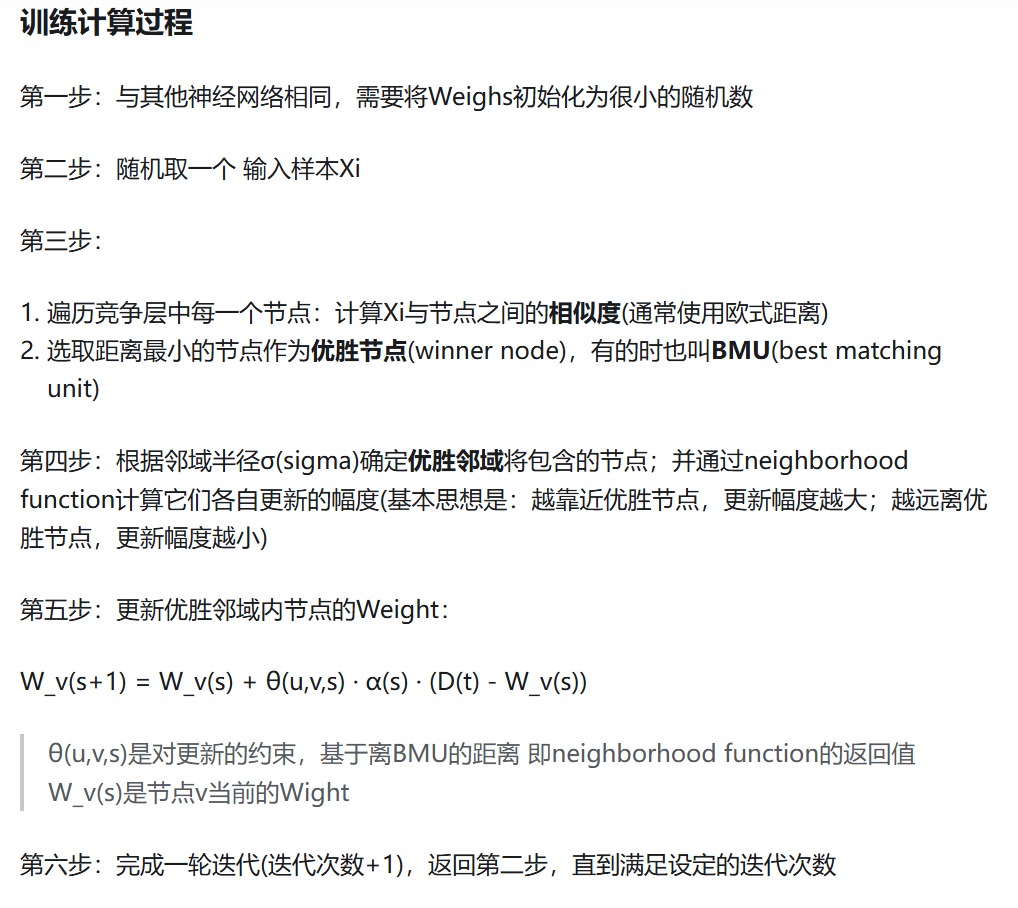

17 2
Epoch 1
quantization_error= 0.4101
Epoch 2
quantization_error= 0.3120
Epoch 3
quantization_error= 0.2577


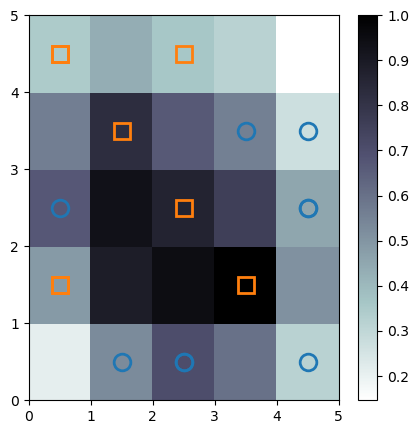

In [3]:
import  numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# 利用高斯距离法计算临近点的权重
# X,Y 模板大小，c 中心点的位置， sigma 影响半径
def gaussion_neighborhood(X,Y,c,sigma):
    xx,yy = np.meshgrid(np.arange(X),np.arange(Y))
    d = 2*sigma*sigma
    ax = np.exp(-np.power(xx-xx.T[c], 2)/d)
    ay = np.exp(-np.power(yy-yy.T[c], 2)/d)
    return (ax * ay).T

# 利用bubble距离法计算临近点的权重
# X,Y 模板大小，c 中心点的位置， sigma 影响半径
def bubble_neighborhood(X,Y,c,sigma):

    neigx = np.arange(X)
    neigY = np.arange(Y)
    
    ax = np.logical_and(neigx > c[0]-sigma,
                     neigx < c[0]+sigma)
    ay = np.logical_and(neigy > c[1]-sigma,
                     neigy < c[1]+sigma)
    return np.outer(ax, ay)*1.

# 计算学习率
def get_learning_rate(lr,t,max_steps):  
    return lr / (1+t/(max_steps/2))

# 计算欧式距离
def euclidean_distance(x, w):
    dis = np.expand_dims(x,axis=(0,1))-w
    return np.linalg.norm(dis, axis=-1)

# 特征标准化 (x-mu)/std
def feature_normalization(data):
    mu = np.mean(data,axis=0,keepdims=True)
    sigma = np.std(data,axis=0,keepdims=True)
    return (data-mu)/sigma

# 获取激活节点的位置
def get_winner_index(x,w,dis_fun=euclidean_distance):
    # 计算输入样本和各个节点的距离
    dis = dis_fun(x,w)
    
    # 找到距离最小的位置
    index = np.where(dis==np.min(dis))
    return (index[0][0],index[1][0])


def weights_PCA(X,Y,data):
    
    N,D = np.shape(data)
    weights = np.zeros([X,Y,D])
    
    pc_length, pc = np.linalg.eig(np.cov(np.transpose(data)))
    pc_order = np.argsort(-pc_length)
    for i, c1 in enumerate(np.linspace(-1, 1, X)):
        for j, c2 in enumerate(np.linspace(-1, 1, Y)):
            weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]
    return weights

# 计算量化误差
def get_quantization_error(datas,weights):
    w_x, w_y = zip(*[get_winner_index(d,weights) for d in datas])
    error = datas - weights[w_x,w_y]
    error = np.linalg.norm(error, axis=-1)
    return np.mean(error)
    
   

def train_SOM(X,
              Y,
              N_epoch,
              datas,
              init_lr = 0.5,
              sigma =0.5,
              dis_fun=euclidean_distance,
              neighborhood_fun=gaussion_neighborhood,
              init_weight_fun = None,
              seed =20):
    
    # 获取输入特征的维度
    N,D = np.shape(datas)
    
    # 训练的步数
    N_steps = N_epoch*N
    
    # 对权重进行初始化
    rng  =  np.random.RandomState(seed)
    if init_weight_fun is None:
        weights = rng.rand(X, Y, D)*2-1
        weights /= np.linalg.norm(weights, axis=-1, keepdims=True)
    else:
        weights = init_weight_fun(X,Y,datas)
    
 
    for n_epoch in range(N_epoch):
        print("Epoch %d"%(n_epoch+1))
        # 打乱次序
        index = rng.permutation(np.arange(N))
        for n_step,_id in enumerate(index):
            
            # 取一个样本
            x = datas[_id]
            
            # 计算learning rate(eta)
            t = N*n_epoch+n_step
            eta = get_learning_rate(init_lr,t,N_steps)
            
            # 计算样本距离每个顶点的距离,并获得激活点的位置
            winner = get_winner_index(x,weights,dis_fun)
            
            # 根据激活点的位置计算临近点的权重
            new_sigma = get_learning_rate(sigma,t,N_steps)
            g = neighborhood_fun(X,Y,winner,new_sigma)
            g = g*eta
            
            # 进行权重的更新         
            weights = weights + np.expand_dims(g,-1)*(x-weights)
            
        # 打印量化误差
        print("quantization_error= %.4f"%(get_quantization_error(datas,weights)))
        
    return weights
         
       
def get_U_Matrix(weights):
    
    X,Y,D = np.shape(weights)
    um = np.nan * np.zeros((X,Y,8)) # 8邻域
    
    ii = [0, -1, -1, -1, 0, 1, 1, 1]   
    jj = [-1, -1, 0, 1, 1, 1, 0, -1]   
    
    for x in range(X):
        for y in range(Y):
            w_2 = weights[x, y]
            
            for k, (i, j) in enumerate(zip(ii, jj)):
                if (x+i >= 0 and x+i < X and y+j >= 0 and y+j < Y):
                    w_1 = weights[x+i, y+j]
                    um[x, y, k] = np.linalg.norm(w_1-w_2)

    
    um = np.nansum(um, axis=2)
    return um/um.max()
    
    
if __name__ == "__main__":
    # 读取数据
    dataset = np.loadtxt('../Data/watermelon_3a.csv',delimiter=',')
    datas = dataset[:,1:3]
    labs = dataset[:,-1].astype(int)
    N,D = np.shape(datas)
    print(N,D)
    
    # 对训练数据进行正则化处理
    datas = feature_normalization(datas)
    
    # SOM的训练
    weights = train_SOM(X=5,Y=5,N_epoch=3,datas=datas,sigma=1.5,init_weight_fun=weights_PCA)
    
    # 获取UMAP
    UM = get_U_Matrix(weights)
    
    plt.figure(figsize=(5, 5))
    plt.pcolor(UM.T, cmap='bone_r')  # plotting the distance map as background
    plt.colorbar()
    
    markers = ['o', 's']
    colors = ['C0', 'C1']
    
    for i in range(N):
        x = datas[i]
        w = get_winner_index(x,weights)
        i_lab = labs[i]
        
        plt.plot(w[0]+.5, w[1]+.5, markers[i_lab], markerfacecolor='None',
             markeredgecolor=colors[i_lab], markersize=12, markeredgewidth=2)
    
    plt.show()